# SpectralDefocusCam Iterative Reconstruction Demo

In [1]:
import matplotlib.pyplot as plt
import scipy.io
import utils.helper_functions as helper
import utils.psf_calibration_utils as psf
import utils.diffuser_utils as diffuser_utils
import inference, train
import torch
import os

# Change this to GPU or CPU depending on your machine 
device = "cuda:3"

%load_ext autoreload
%autoreload 2

In [2]:
if "cuda" in device:
    import cupy as np
else:
    import numpy as np

### View calibration data and image

In [3]:
defocuscamdata_path = "/home/cfoley_waller/defocam/defocuscamdata"
calib_mat_path_rel = "calibration_data/DMM_37UX178_ML_calib_data/calib_matrix_9_22_2023_exp0.5ms_378-890/calibration_matrix.mat"
psf_path_rel = "calibration_data/DMM_37UX178_ML_calib_data/psfs_9_22_2023_noiseavg32"
data_path_rel = "sample_data"
data_split = (0.7,0.15,0.15)
patch_size = [256,256]
image_index = 15

# calibration matrix
mask = diffuser_utils.load_mask(os.path.join(defocuscamdata_path, calib_mat_path_rel), patch_size)

# measured PSF
psf.get_psf_stack(os.path.join(defocuscamdata_path, psf_path_rel), 3, mask.shape)

# sample data
base_data_path = os.path.join(defocuscamdata_path, data_path_rel)
_, _, test_loader = inference.ds.get_data(1, data_split, base_data_path)
img = test_loader.dataset.__getitem__(image_index)

In [16]:
helper.plt3D(mask, title="Spectral calibration matrix")

interactive(children=(IntSlider(value=1, description='r', max=29), Output()), _dom_classes=('widget-interact',…

In [26]:

helper.plt3D(img['image'].numpy().transpose(1,2,0), title="Test hyperspectral image (ground truth)")

interactive(children=(IntSlider(value=1, description='r', max=29), Output()), _dom_classes=('widget-interact',…

### Initialize forward model

In [41]:
config = {
    "mask_dir": os.path.join(defocuscamdata_path, calib_mat_path_rel),
    "psf_dir": os.path.join(defocuscamdata_path, psf_path_rel),
    "forward_model_params": {
        "stack_depth": 8,
        "sim_blur": True,
        "sim_meas": True,
        "optimize_blur": False,
        "blur_type": "symmetric",
        "apply_adjoint": False,
        "spectral_pad_output": False,
    },
    "recon_model_params": {
        "model_name": "fista",
        "iters": 500,
        "prox_method": 'tv',
        "tv_lambda": .003,
        "tv_lambdaw": 0.01,
        "lowrank_lambda": 0.00005
    },
    "batch_size": 1,
    "patch_size": [256, 256],

}
#with torch.no_grad():
model = train.get_model(config, device=device)

device =  cuda:3 , using GPU and cupy
<class 'cupy.core.core.ndarray'> <class 'cupy.core.core.ndarray'>


## Run model with fista recon

In [42]:
print(model.model1.w_blur)

Parameter containing:
tensor([0.0020, 0.0517, 0.1014, 0.1511, 0.2009, 0.2506, 0.3003, 0.3500],
       device='cuda:3')


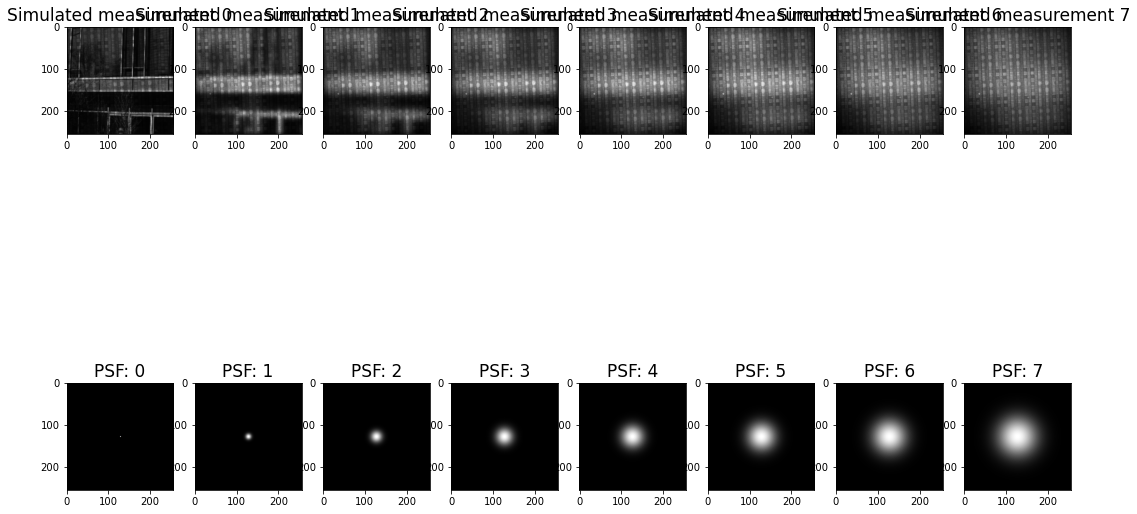

In [43]:
# Let's look at the simulated images and psfs
sim_output = model.model1(img['image'].unsqueeze(0).to(device))[0,:,0,:,:]
psfs = model.model1.psfs

fig, ax = plt.subplots(2,8,figsize=(18,12))

for i, im in enumerate(sim_output):
    ax[0][i].imshow(im.cpu().numpy(), cmap = "gray")
    ax[1][i].imshow(psfs[i].cpu().numpy(), cmap = "gray")
    ax[0][i].set_title(f"Simulated measurement {i}", fontsize=17)
    ax[1][i].set_title(f"PSF: {i}", fontsize=17)
    
plt.show()

iteration:  0  loss:  334818.1219530927


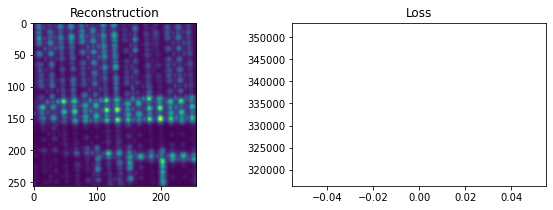

iteration:  20  loss:  35777.6002101365


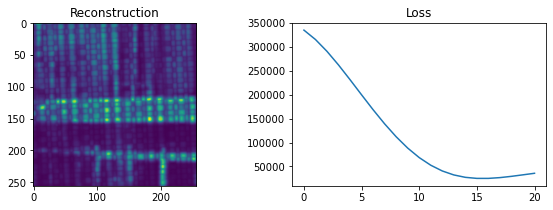

iteration:  40  loss:  18803.987769581923


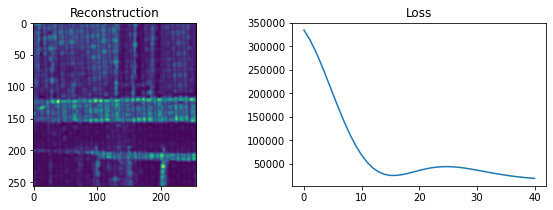

iteration:  60  loss:  18393.98236077871


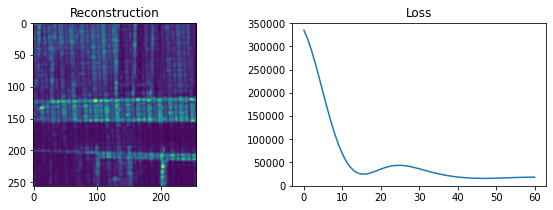

iteration:  80  loss:  14645.586529503998


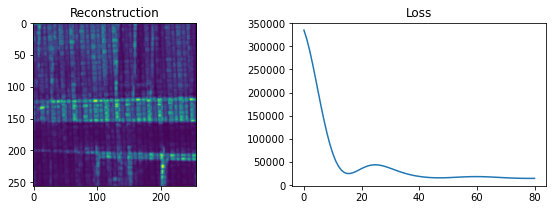

iteration:  100  loss:  17009.062784046902


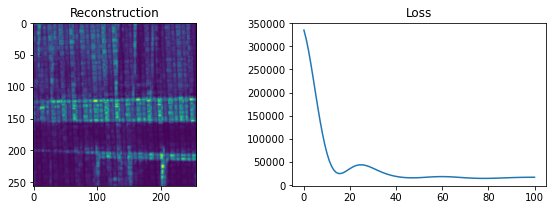

iteration:  120  loss:  15448.56912172997


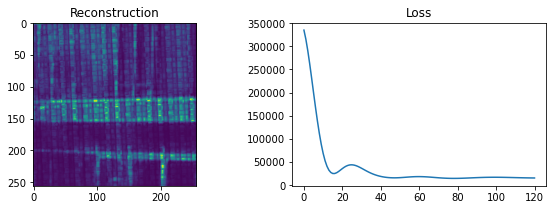

iteration:  140  loss:  15516.237348006458


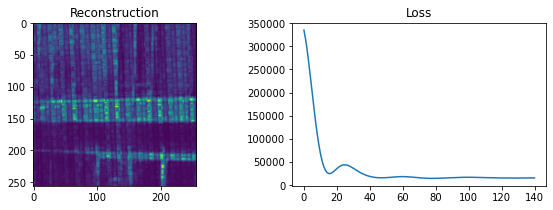

iteration:  160  loss:  15710.623364491852


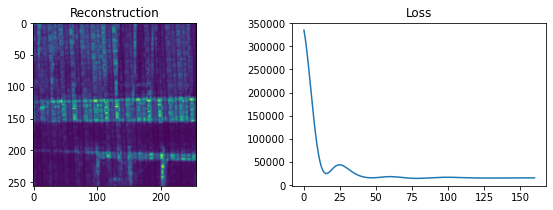

iteration:  180  loss:  15491.86321550533


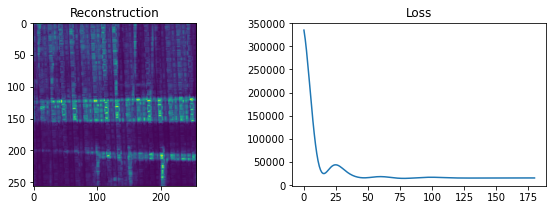

iteration:  200  loss:  15447.745362432135


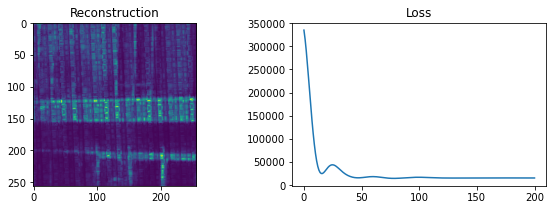

iteration:  220  loss:  15416.991868973848


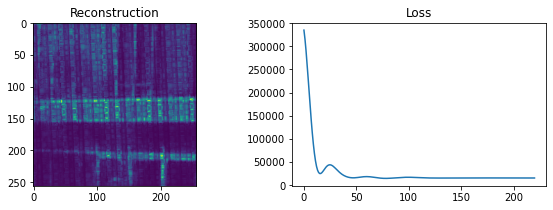

iteration:  240  loss:  15376.772416376416


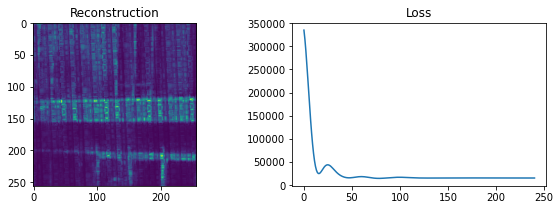

iteration:  260  loss:  15328.27857462698


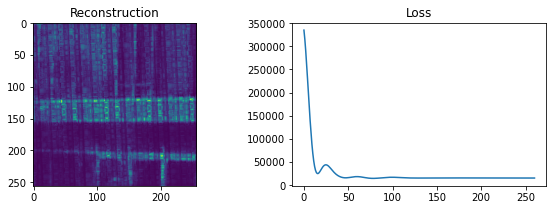

iteration:  280  loss:  15268.451472333029


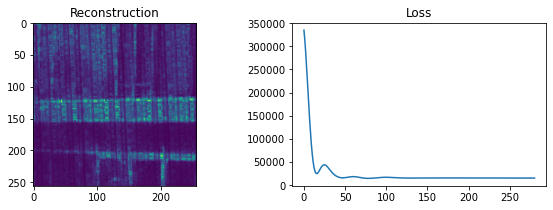

iteration:  300  loss:  15238.497622980878


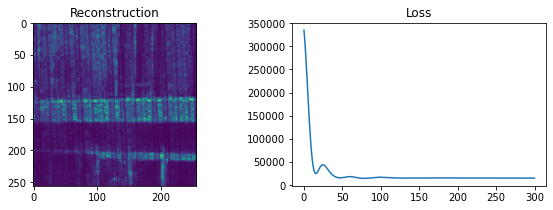

iteration:  320  loss:  15231.148117042188


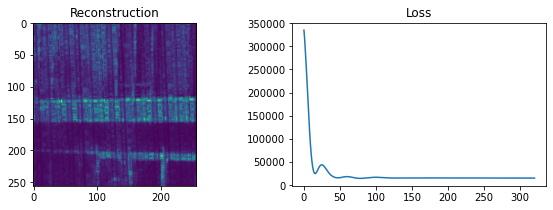

iteration:  340  loss:  15189.196952446444


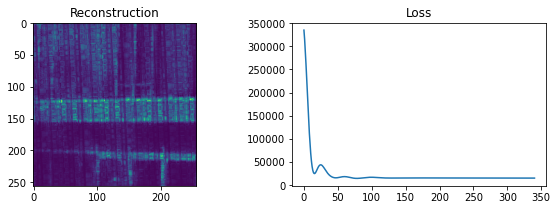

iteration:  360  loss:  15169.769862227184


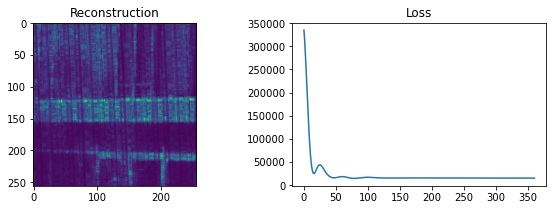

iteration:  380  loss:  15145.011387829842


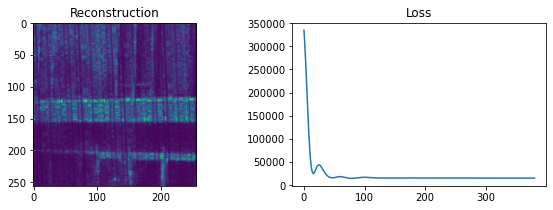

iteration:  400  loss:  15128.950145125547


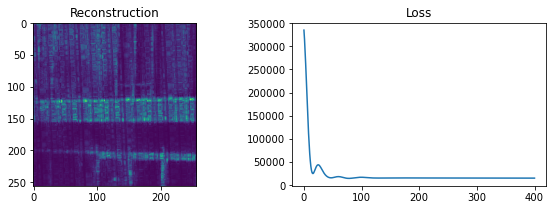

iteration:  420  loss:  15099.325600572636


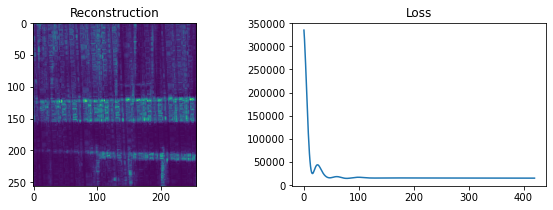

iteration:  440  loss:  15082.555197615673


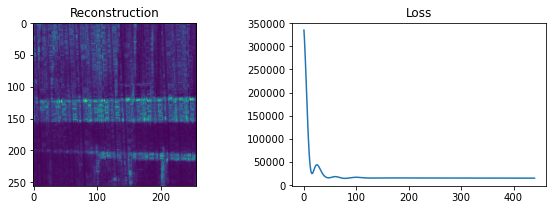

iteration:  460  loss:  15064.644403768687


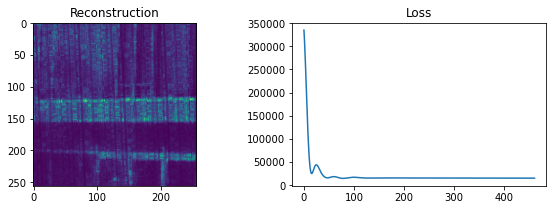

iteration:  480  loss:  15038.460937566766


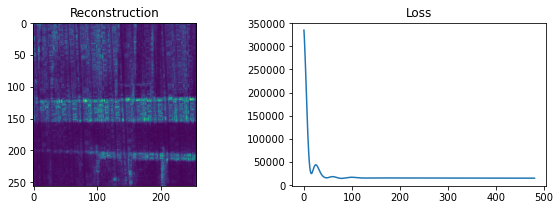

In [162]:
out = model(img['image'].unsqueeze(0).to(device))

iteration:  0  loss:  1310.149210652239


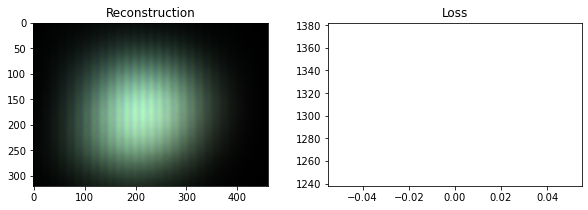

iteration:  20  loss:  118.67611242874175


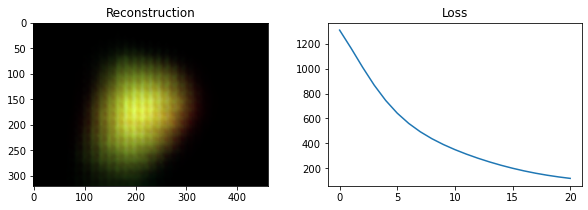

iteration:  40  loss:  38.47145335614469


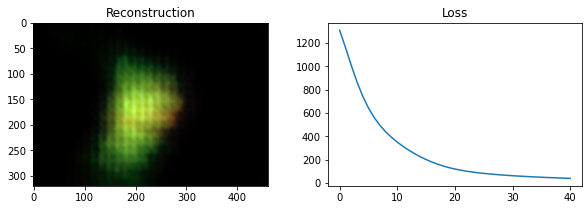

iteration:  60  loss:  20.37078478069985


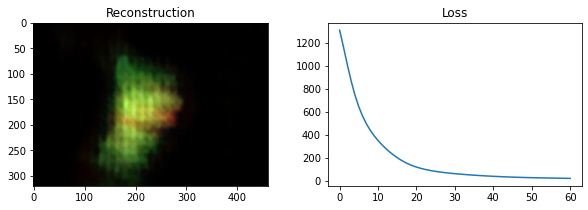

iteration:  80  loss:  13.534314943438323


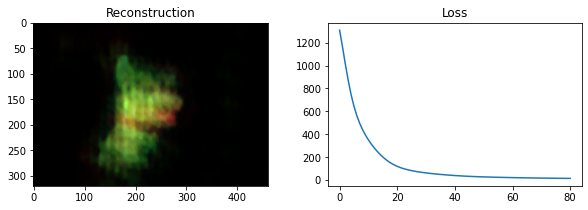

iteration:  100  loss:  10.469084407325292


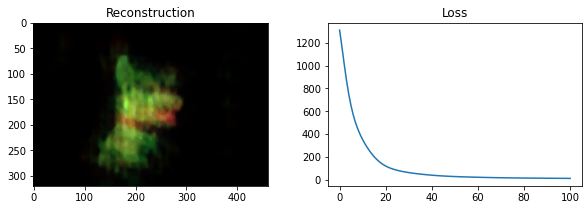

iteration:  120  loss:  9.119691485922337


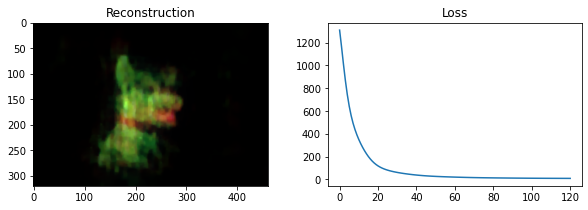

iteration:  140  loss:  8.348514397036576


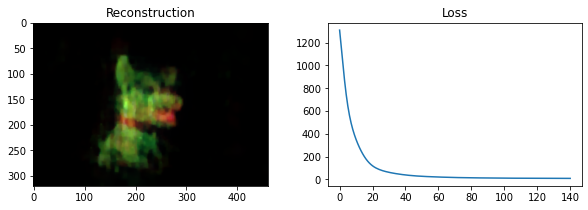

iteration:  160  loss:  7.760140856460749


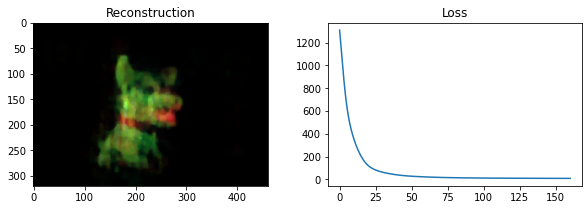

iteration:  180  loss:  7.302716145924632


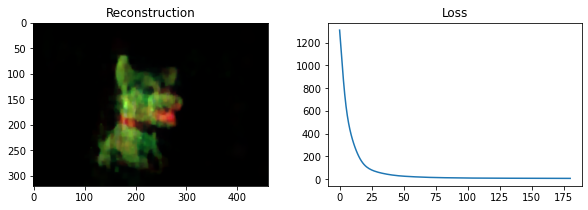

iteration:  200  loss:  6.966299789440718


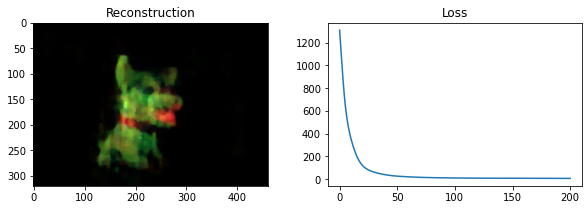

iteration:  220  loss:  6.7273192258888574


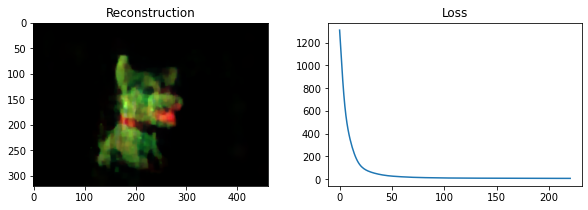

iteration:  240  loss:  6.53301202307326


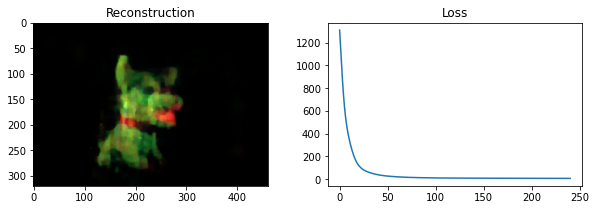

iteration:  260  loss:  6.3658416386485195


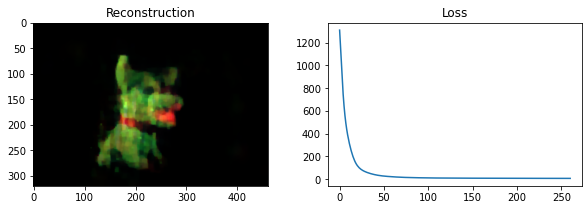

iteration:  280  loss:  6.224319832119829


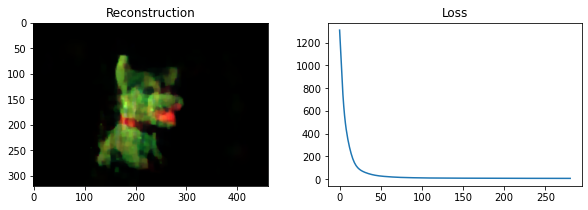

iteration:  300  loss:  6.112272319371023


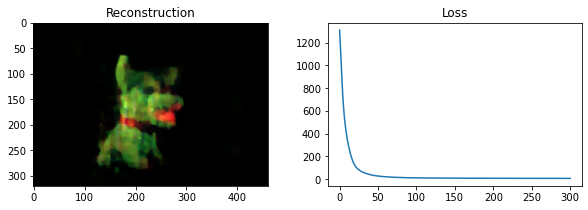

iteration:  320  loss:  6.027507138355055


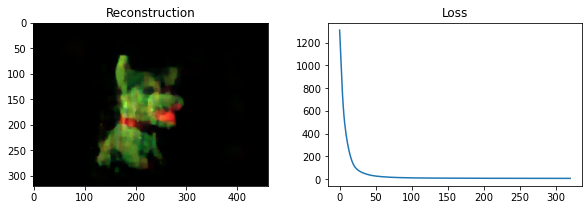

iteration:  340  loss:  5.960653213654994


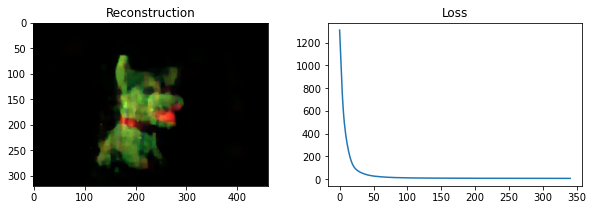

iteration:  360  loss:  5.903362577958905


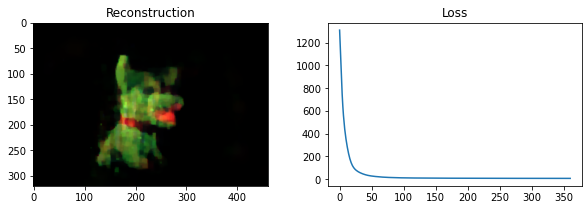

iteration:  380  loss:  5.852807559123385


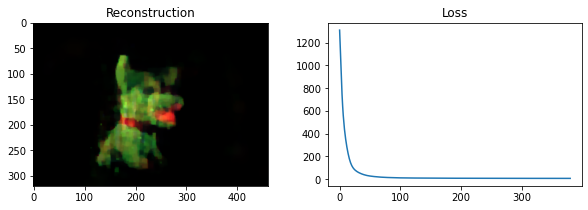

iteration:  400  loss:  5.809511494136097


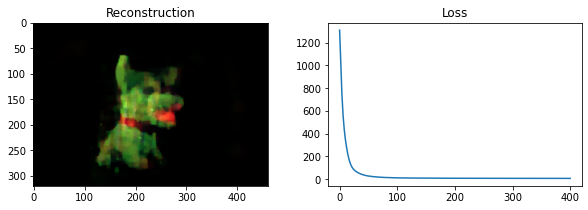

iteration:  420  loss:  5.773387336717086


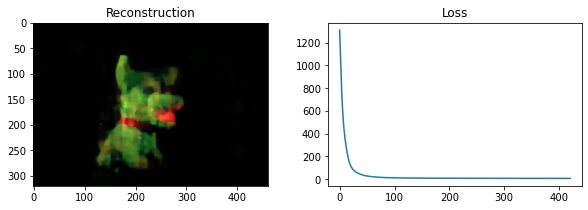

iteration:  440  loss:  5.7427646827137275


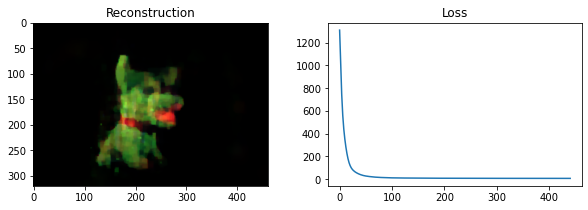

iteration:  460  loss:  5.71605222298559


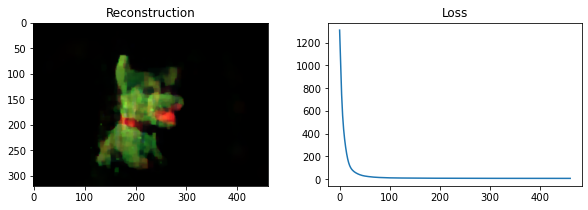

iteration:  480  loss:  5.692229493175099


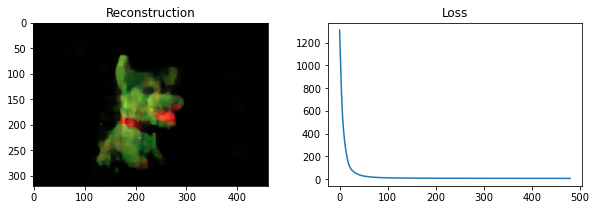

In [8]:
out_img = model(img)

In [9]:
out_img = fista.out_img
fc_img = helper.pre_plot(helper.stack_rgb_opt(out_img))


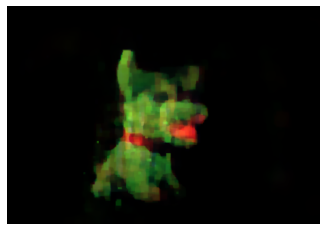

In [10]:
plt.imshow(fc_img); plt.axis('off');

In [11]:
helper.plt3D(helper.pre_plot(out_img))

interactive(children=(IntSlider(value=1, description='r', max=63), Output()), _dom_classes=('widget-interact',…